In [1]:
import os 
import mne
import numpy as np
import torch
import torch.nn as nn
import torchvision
from functools import partial
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
def scale_clamp(X: np.ndarray, clamp_lim: float = 5.0, clamp: bool = True) -> np.ndarray:
  X = X.reshape(X.shape[0], -1)
  X = RobustScaler().fit_transform(X)
  if clamp:
      X = X.clip(min=-clamp_lim, max=clamp_lim)
  return X.squeeze()


class meg_dataset(torch.utils.data.Dataset):
  def __init__(self, root, s: str):
    self.root = root
    nights = ['night1', 'night2']

    self.all_meg_data = []
    self.all_epochs = []
    for night in nights:
      data_path_folder = os.path.join(self.root, rf'{s}\{night}')
      wm = os.listdir(data_path_folder)[-1]
      self.data_path = os.path.join(self.root, rf'{s}\{night}\{wm}')

      raw = mne.io.read_raw_ctf(self.data_path, preload=True)
      raw.pick_types(meg=True, stim=True, eeg=True, ref_meg=True)
      events = mne.find_events(raw, stim_channel='UDIO001', initial_event=True)
      event_ids = {"maint_FACE": 43, "maint_HOUSE": 53}

      events[:,2] = events[:,2] - 255
      sel = np.where(events[:, 2] <= 255)[0]
      events = events[sel, :]
      picks = mne.pick_types(raw.info, meg='mag', eeg=True, stim=False,
                              exclude='bads')
      self.epochs = mne.Epochs(raw, events, event_ids,  picks=picks,tmin=-.2, tmax=4,\
                          baseline=None, preload=True)
      self.epochs.resample(120)
      self.epochs.apply_function(partial(scale_clamp, clamp_lim=5.0), n_jobs=8)
      self.meg_data = torch.from_numpy(self.epochs.get_data(picks='meg')).to(torch.float32)
      self.all_meg_data.append(self.meg_data)
      self.all_epochs.append(self.epochs)

    self.all_meg_data = torch.cat(self.all_meg_data, dim=0)
    for ep in self.all_epochs:
      ep.info['dev_head_t'] = self.all_epochs[0].info['dev_head_t']
    self.all_epochs = mne.concatenate_epochs(self.all_epochs)
    
  def __len__(self):
    return len(self.all_meg_data)
  
  def __getitem__(self, idx):
    return self.all_meg_data[idx, :, :], self.all_epochs.events[idx, 2]

In [4]:

class CustomBatchNorm1d(nn.BatchNorm1d):
    def forward(self, input):
        if input.size(0) == 1:
            return input
        return super().forward(input)

class NaiveModel(nn.Module):
    def __init__(self, backbone: nn.Module):
        super().__init__()

        self.backbone = backbone

        out_features = list(self.backbone.modules())[-1].out_features
        
        self.cls_head = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(out_features, 512),
            CustomBatchNorm1d(512),
            nn.ReLU(),

            nn.Dropout(p=0.5),
            nn.Linear(512, 128),
            CustomBatchNorm1d(128),
            nn.ReLU(),

            nn.Dropout(p=0.5),
            nn.Linear(128, 64),
            CustomBatchNorm1d(64),
            nn.ReLU(),

            nn.Dropout(p=0.5),
            nn.Linear(64, 2),
        )

    def forward(self, x):
        x = self.backbone(x)
        
        output = self.cls_head(x)
        return output

In [5]:
dataset = meg_dataset(root = r'\\memo-15\DataE\MEGA\raw', s = 'S02')

train_idcs = np.arange(0, len(dataset))
np.random.shuffle(train_idcs)
train_idcs = train_idcs[:int(len(train_idcs)*0.8)]
test_idcs = np.setdiff1d(np.arange(0, len(dataset)), train_idcs)
train_idcs = torch.from_numpy(train_idcs).to(device)
test_idcs = torch.from_numpy(test_idcs).to(device)
train_dataset = torch.utils.data.Subset(dataset, train_idcs)
test_dataset = torch.utils.data.Subset(dataset, test_idcs)


clear_output()

800 640 160
torch.Size([296, 504]) 43


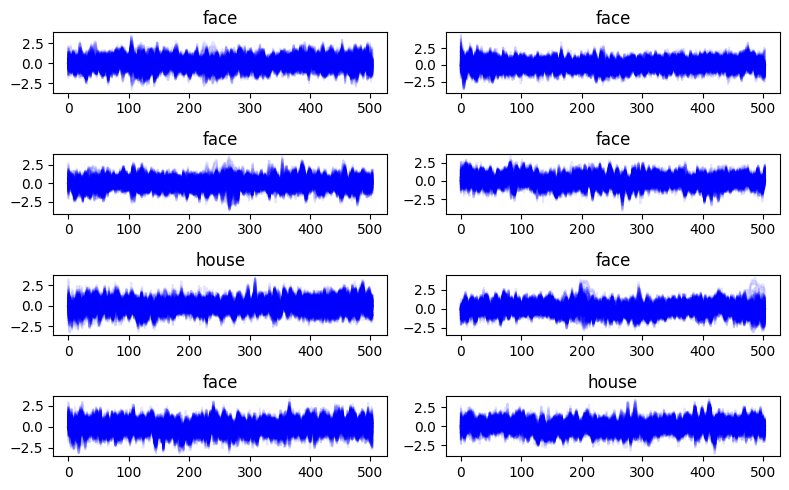

In [6]:
print(len(dataset), len(train_dataset), len(test_dataset))
fig, ax = plt.subplots(4, 2, figsize=(8, 5))
for idx, ax in enumerate(ax.flatten()):
    np.random.seed(idx)
    rnd_int = np.random.randint(0, len(dataset))
    meg, label = dataset[np.random.randint(0, len(dataset))]
    for i in range(meg.shape[0]):
        ax.plot(meg[i, :].numpy(), color='blue', alpha=0.1)
    ax.set_title(f'{'house' if label == 43 else 'face'}')
print(meg.shape, label)
plt.tight_layout()
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
backbone = torchvision.models.resnet18(weights=None)
backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model = NaiveModel(backbone).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
test_loss = []
train_loss = []
for epoch in range(20):
    model.train()
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}', unit='batch', leave=False)
    lossinho = 0
    for idx, (data, target) in enumerate(progress_bar):
        target = [0 if i == 43 else 1 for i in target]
        data = data.reshape(data.shape[0], 1, data.shape[1], data.shape[2])
        data, target = data.to(device), torch.tensor(target).to(device)
        output = model(data)
        loss = loss_fn(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lossinho += loss.item()
        progress_bar.set_postfix(loss=lossinho/(idx+1))
    print(f'Epoch {epoch+1} Loss: {lossinho/len(train_loader):.4f}')
    train_loss.append(lossinho/len(train_loader))

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        lossinho = 0
        for data, target in test_loader:
            target = [0 if i == 43 else 1 for i in target]
            data = data.reshape(data.shape[0], 1, data.shape[1], data.shape[2])
            data, target = data.to(device), torch.tensor(target).to(device)
            output = model(data)
            loss = loss_fn(output, target)
            lossinho += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        accuracy = 100 * correct / total
        print(f'Accuracy: {accuracy:.2f}%, Loss: {lossinho/len(test_loader):.4f}')
    test_loss.append(lossinho/len(test_loader))

Epoch 1 Loss: 0.7771
Accuracy: 47.50%, Loss: 0.6945


Epoch 2 Loss: 0.7608
Accuracy: 47.50%, Loss: 0.6937


Epoch 3:  10%|█         | 1/10 [00:04<00:38,  4.29s/batch, loss=0.771]

In [ ]:
plt.plot